# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [107]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [108]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_

(784, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [109]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["QT"] = "Other"
dataset.loc[dataset.is_joint_embedding_text_query, "QT"] = "Text"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["category"]=="TEXT","QueryLen"] = dataset.loc[dataset["category"]=="TEXT","value"].str.len()
dataset.loc[dataset["category"]=="TEXT","QueryWords"] = dataset.loc[dataset["category"]=="TEXT","value"].str.split().str.len()

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,Text,49,8
112,112,112,vbs23-kis-v-m2,vibro,1,1673271280000,29638,45672.0,1.0,4.0,...,video Molok,{},NaN,False,False,None,visual,Other,-1,-1
113,113,113,vbs23-kis-v-m3,vibro,1,1673271639000,15343,24472.0,3.0,6.0,...,black and white dotted snake hiding,{},NaN,False,True,"[-115, -128, 125, 123, 121, -122, 125, -127, -118, 125, 120, 116, 125, 125, 125, 118, 122, -116, -128, 125, 125, -119, -117, -126, 118, 126, -128, -121, -121, -122, 122, -116, -122, 125, -118, 126, 124, 126, 126, 120, 115, -125, -122, -122, 118, -125, 124, 115, -118, -123, 124, 127, 125, 126, -123, -127, 123, 127, -124, -127, 118, -123, 122, -126, 121, 126, 120, -126, 124, -128, -126, -126, 124, 125, 121, 122, -127, -127, 126, 119, -128, -127, 126, 118, -122, -121, 127, 122, -124, 124, -125, 109, 113, 118, -124, 119, 115, -118, 125, 124, ...]",visual,Text,36,6
114,114,114,vbs23-kis-v-m4,vibro,1,1673272419000,45815,211429.0,505.0,505.0,...,fishes over corals,{},NaN,False,True,"[124, 126, 121, 121, 121, -119, -127, -128, 118, -125, 127, 124, -128, 124, -124, 126, -127, -123, -124, 126, 124, -125, -127, -127, -124, -128, 126, 123, 126, -125, 116, -119, 124, -125, -127, 121, 117, -117, -125, -127, -127, -128, -124, -123, -126, -126, 126, 116, 127, 121, 122, 124, -123, -123, -127, 119, -117, 124, -127, -127, 125, -115, 125, -126, 121, -125, 127, -124, -127, 127, 127, -127, 120, -128, 118, -118, -126, 126, 124, 122, -118, 125, -126, 118, -125, -128, 126, 122, -122, 124, 127, 121, -119, 120, -121, -125, -123, 127, -125, 127, ...]",visual,Text,18,3
115,115,115,vbs23-kis-v-m4,vibro,1,1673272427000,53815,211429.0,393.0,393.0,...,fishes over corals with blue water,{},NaN,False,True,"[121, 126, 119, 122, 123, -120, 127, -128, 115, -126, -127, 124, -127, 121, -120, -127, 124, -121, -128, -127, -125, -121, -125, -128, -122, 123, 124, 124, 121, -127, 117, -123, 125, -124, -126, 123, 115, -119, -122, -126, -127, 127, -128, -121, -125, 126, -128, 121, -127, 123, 124, 127, -123, -127, -124, 117, -116, 124, -127, 125, 126, -115, 121, -125, 120, -122, -128, -124, -127, 125, 124, 125, 122, -126, 116, -115, 126, 118, 122, 121, -119, 123, -124, 116, 127, -125, 125, 122, -123, 121, -126, 122, -117, 113, -121, -125, -116, -127, -120, 127, ...]",visual,Text,34,6


In [110]:
# percentage of how many rows per team belong to a text query and an image query
counts = dataset.groupby(["team","QT"])[["value"]].count()
((counts / dataset.groupby(["team"])[["value"]].count())*100).round(1)

value
team       QT          
CVHunter   Other   36.4
           Text    63.6
VISIONE    Other    3.5
           Text    96.5
Verge      Other    8.6
           Text    91.4
vibro      Other   47.9
           Text    52.1
vitrivr-VR Text   100.0

In [111]:
((counts / dataset.groupby(["team"])[["value"]].count())*100).round(1).to_latex()

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\2396853172.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ((counts / dataset.groupby(["team"])[["value"]].count())*100).round(1).to_latex()


'\\begin{tabular}{llr}\n\\toprule\n           &      &  value \\\\\nteam & QT &        \\\\\n\\midrule\nCVHunter & Other &   36.4 \\\\\n           & Text &   63.6 \\\\\nVISIONE & Other &    3.5 \\\\\n           & Text &   96.5 \\\\\nVerge & Other &    8.6 \\\\\n           & Text &   91.4 \\\\\nvibro & Other &   47.9 \\\\\n           & Text &   52.1 \\\\\nvitrivr-VR & Text &  100.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [112]:
# how many rows per team belong to a text query and an image query
counts = dataset.groupby(["team","QT"])[["value"]].count()
counts.loc[((counts["value"]>=10)&(counts.index.get_level_values('QT')!="None"))]

value
team       QT          
CVHunter   Other     84
           Text     147
VISIONE    Text     167
Verge      Other     13
           Text     139
vibro      Other     80
           Text      87
vitrivr-VR Text      61

### Comparison of visual and textual KIS tasks:

In [113]:
# how many text and visual KIS where solved by which query type
vt_counts = dataset.groupby(["task_type", 'QT'])[["value"]].count()
vt_counts = vt_counts.loc[((vt_counts.index.get_level_values('QT')!="None"))]
vt_counts

value
task_type QT          
textual   Other     66
          Text     269
visual    Other    117
          Text     332

In [114]:
# percentage of the previous
vt_counts.div(vt_counts.groupby('task_type').transform('sum'))

value
task_type QT             
textual   Other  0.197015
          Text   0.802985
visual    Other  0.260579
          Text   0.739421

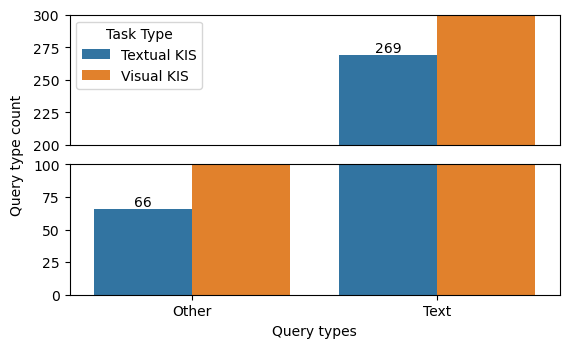

In [115]:
textual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "textual", "value"].tolist()
visual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "visual", "value"].tolist()

barplot_df = pd.DataFrame({
    'Query Types': ["Other", "Text"],
    'Textual KIS': textual_values,
    'Visual KIS': visual_values
})

#fig, ax1 = plt.subplots(figsize=(7, 6))
tidy = barplot_df.melt(id_vars='Query Types').rename(columns=str.title)
tidy = tidy.rename(columns={"Value": "Query Type Count", "Variable": "Task Type", "Query Types": "Query types"})

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True, figsize=(7, 4))

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(200, 300)
ax2.set_ylim(0, 100)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.065, 0.5, "Query type count", va="center", rotation="vertical")

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
#ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
#ax2.legend(loc=(1.025, 0.5), title="Design")

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85, hspace=0.15)

for container in ax1.containers:
    ax1.bar_label(container)
for container in ax2.containers:
    ax2.bar_label(container)

plt.savefig(f'./query_type_vs_task_type.pdf', format='pdf', bbox_inches="tight")
plt.show()


### General per-team statistics from text queries:

In [116]:
#append dummy values for too high ratings (have to be labeled in plots properly in charts)
dataset.loc[dataset.rank_video > unknownRankLimit,"rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit,"rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit,"rank_shot_margin_5"] = unknownRankValue

medianStats = dataset.groupby(["team","QT"])[["QueryWords","QueryLen","rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()
medianStats

QueryWords  QueryLen  rank_shot_margin_0  \
team       QT                                                
CVHunter   Other        -1.0      -1.0              2000.0   
           Text          8.0      46.0               855.0   
VISIONE    Other        -1.0      -1.0              1075.5   
           Text         15.0      75.0               297.0   
Verge      Other        -1.0      -1.0              2000.0   
           Text          5.0      28.0               877.0   
vibro      Other        -1.0      -1.0               418.5   
           Text          7.0      35.0               414.0   
vitrivr-VR Text          6.0      32.0              2000.0   

                  rank_shot_margin_5  rank_video  
team       QT                                     
CVHunter   Other               586.0       297.5  
           Text                751.0       288.0  
VISIONE    Other              1075.5      1075.5  
           Text                242.0       142.0  
Verge      Other              2000.0      2000.0  
           Text                701.0       275.0  
vibro      Other               359.0       119.0  
           Text                276.0        75.0  
vitrivr-VR Text               2000.0       146.0

In [117]:
textData = dataset.loc[dataset["QT"]=="Text"]
meanQueryStats = textData.groupby("team")[["QueryWords","QueryLen"]].mean()
meanQueryStats["QT"] = "Text"
meanQueryStats = meanQueryStats.set_index("QT", append=True)
meanQueryStats

,,QueryWords,QueryLen
team,QT,,
CVHunter,Text,9.469388,52.693878
VISIONE,Text,16.670659,85.089820
Verge,Text,5.000000,28.165468
vibro,Text,7.126437,38.275862
vitrivr-VR,Text,6.639344,33.983607


# Effectivity of text queries in general per team
- "topX" depict a percentage of queries, where the correct object was within top-x results
- ">1000" depict a percentage of queries whose results was worse than top-1000
### Finding correct scene

In [118]:
restrData = dataset
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_0 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","QT"]).count()["rank_shot_margin_0"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
resTab1 = topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

# in the end we want mean stats
resTab1["Words per query"] = meanQueryStats["QueryWords"]
resTab1["Query length"] = meanQueryStats["QueryLen"]
resTab1

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\2192693912.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Words per query"] = meanQueryStats["QueryWords"]
C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\2192693912.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Query length"] = meanQueryStats["QueryLen"]


Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Other             84              NaN           NaN   4.8    4.8   
           Text             147         9.469388     52.693878   4.1   10.9   
VISIONE    Text             167        16.670659     85.089820   9.0   10.8   
Verge      Other             13              NaN           NaN   7.7   15.4   
           Text             139         5.000000     28.165468   0.7    0.7   
vibro      Other             80              NaN           NaN   2.5    3.8   
           Text              87         7.126437     38.275862   8.0   11.5   
vitrivr-VR Text              61         6.639344     33.983607   3.3    9.8   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Other    8.3   13.1    20.2    25.0    39.3   51.2  
           Text    12.2   15.0    20.4    29.9    42.2   46.3  
VISIONE    Text    16.8   25.7    31.7    41.9    55.7   36.5  
Verge      Other   15.4   15.4    23.1    23.1    30.8   53.8  
           Text     1.4    2.9     4.3    27.3    34.5   47.5  
vibro      Other   11.2   23.8    31.2    36.2    53.8   38.8  
           Text    19.5   28.7    33.3    39.1    50.6   32.2  
vitrivr-VR Text    13.1   14.8    16.4    24.6    24.6   63.9

## Finding correct scene with slightly larger margins (+5sec)

In [119]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_5 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top5 = restrData.loc[restrData.rank_shot_margin_5 < 5].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top10 = restrData.loc[restrData.rank_shot_margin_5 < 10].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top20 = restrData.loc[restrData.rank_shot_margin_5 < 20].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top50 = restrData.loc[restrData.rank_shot_margin_5 < 50].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top100 = restrData.loc[restrData.rank_shot_margin_5 < 100].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top200 = restrData.loc[restrData.rank_shot_margin_5 < 200].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top500 = restrData.loc[restrData.rank_shot_margin_5 < 500].groupby(["team","QT"]).count()["rank_shot_margin_5"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Other             84             -1.0          -1.0   6.0    6.0   
           Text             147              8.0          46.0   4.8   11.6   
VISIONE    Text             167             15.0          75.0   9.6   10.8   
Verge      Other             13             -1.0          -1.0   7.7   15.4   
           Text             139              5.0          28.0   0.7    0.7   
vibro      Other             80             -1.0          -1.0   2.5    3.8   
           Text              87              7.0          35.0   8.0   12.6   
vitrivr-VR Text              61              6.0          32.0   3.3    9.8   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Other    9.5   14.3    23.8    31.0    46.4   45.2  
           Text    12.2   15.0    20.4    32.0    44.9   45.6  
VISIONE    Text    16.8   25.7    32.3    46.1    60.5   30.5  
Verge      Other   15.4   15.4    23.1    23.1    30.8   53.8  
           Text     6.5    9.4    12.9    36.7    44.6   42.4  
vibro      Other   11.2   26.2    33.8    40.0    58.8   32.5  
           Text    24.1   36.8    42.5    44.8    57.5   21.8  
vitrivr-VR Text    13.1   14.8    16.4    24.6    24.6   63.9

## Finding correct video

In [120]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_video > unknownRankLimit].groupby(["team","QT"]).count()["rank_video"]
top5 = restrData.loc[restrData.rank_video < 5].groupby(["team","QT"]).count()["rank_video"]
top10 = restrData.loc[restrData.rank_video < 10].groupby(["team","QT"]).count()["rank_video"]
top20 = restrData.loc[restrData.rank_video < 20].groupby(["team","QT"]).count()["rank_video"]
top50 = restrData.loc[restrData.rank_video < 50].groupby(["team","QT"]).count()["rank_video"]
top100 = restrData.loc[restrData.rank_video < 100].groupby(["team","QT"]).count()["rank_video"]
top200 = restrData.loc[restrData.rank_video < 200].groupby(["team","QT"]).count()["rank_video"]
top500 = restrData.loc[restrData.rank_video < 500].groupby(["team","QT"]).count()["rank_video"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Other             84             -1.0          -1.0  11.9   11.9   
           Text             147              8.0          46.0   5.4   14.3   
VISIONE    Text             167             15.0          75.0  12.0   16.2   
Verge      Other             13             -1.0          -1.0   7.7   15.4   
           Text             139              5.0          28.0   3.6    4.3   
vibro      Other             80             -1.0          -1.0  12.5   18.8   
           Text              87              7.0          35.0  19.5   24.1   
vitrivr-VR Text              61              6.0          32.0  14.8   18.0   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Other   19.0   20.2    27.4    40.5    60.7   33.3  
           Text    17.7   21.8    27.9    42.2    57.1   34.7  
VISIONE    Text    21.6   35.3    43.7    57.5    68.3   26.3  
Verge      Other   15.4   15.4    23.1    23.1    38.5   53.8  
           Text    14.4   20.1    25.2    46.8    59.7   28.1  
vibro      Other   23.8   35.0    46.2    66.2    78.8   10.0  
           Text    34.5   46.0    52.9    62.1    74.7   11.5  
vitrivr-VR Text    23.0   34.4    44.3    55.7    63.9   23.0

## TODO Observations:
- the vibro, VISIONE, vitrivr-VR had similar full text retrieval models (CLIP)
- CVHunter and vibro used successfully their image retrieval models
- CVHunter has even better results with the image retrieval than text retrieval
- the text retrieval quality is still lower than the text retrieval of vibro, VISIONE, vitrivr-VR
- vibro has the best retrieval results for all top-k region and is only beaten by its own image retrieval in the top200 and top500 region
- VISIONE in general created lagest queries (QueryWords, QueryLen), but might be becasue of the temporal queries which where combined here to one string

# Ranking vs. Query length and Query words

In [121]:
textDataWithLength = textData.loc[textData.QueryLen > -1]
textDataWithLength.shape

(590, 24)

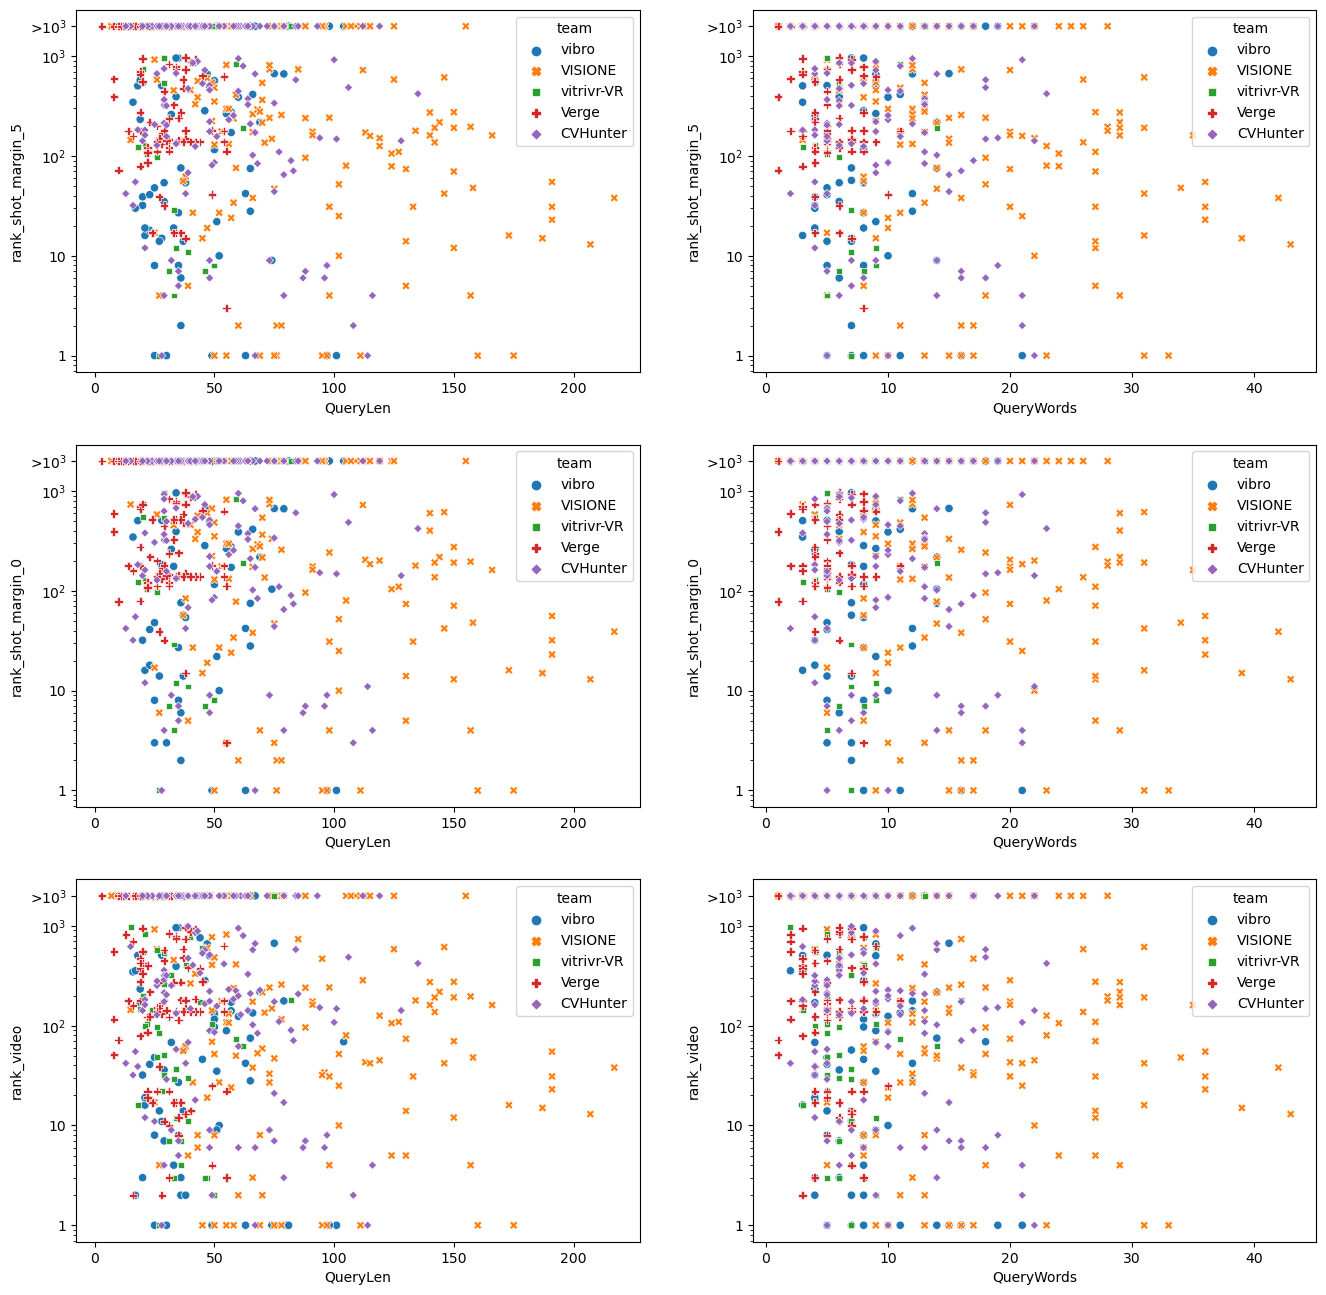

In [122]:
lenParam = ["QueryLen","QueryWords"]
resParam = ["rank_shot_margin_5","rank_shot_margin_0","rank_video"]

fig,ax = plt.subplots(3,2,figsize=(16,16))

for j,lenPar in enumerate(lenParam):
    for i,resPar in enumerate(resParam):
    
        sns.scatterplot(data=textDataWithLength,x=lenPar,y=resPar,style="team", hue="team", ax=ax[i,j])
        ax[i,j].set_yscale("log")

        ax[i,j].set_yticks([1,10,100,1000,2000])
        ax[i,j].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


- Really, not much to see, unfortunatelly. 
  - There is (very mild) negative correlation between rank and query length and #words
  - The difference rises up a bit when queries with >1000 results are considered, but not much

In [123]:
textDataKnownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 < unknownRankValue]
textDataUnknownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 >= unknownRankValue]
textDataKnownShotRanking[["QueryLen","QueryWords","rank_shot_margin_0"]].corr()

,QueryLen,QueryWords,rank_shot_margin_0
QueryLen,1.000000,0.987609,-0.213718
QueryWords,0.987609,1.000000,-0.230660
rank_shot_margin_0,-0.213718,-0.230660,1.000000


## Are there any dependencies between query length and ability to get decent ranks?
- comparing query statistics for ranks <=1000 and >1000

In [124]:
textDataUnknownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      44.125954
QueryWords     8.175573
dtype: float64

In [125]:
textDataKnownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      60.134146
QueryWords    11.478659
dtype: float64

In [126]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_shot_margin_0 <= 1000),"rankCat"] = "1-1000"
#textData.loc[textData.rank_shot_margin_0 <= 10,"rankCat"] = "1-10"
#textData.loc[((textData.rank_shot_margin_0 > 10)&(textData.rank_shot_margin_0 <= 100)),"rankCat"] = "11-100"
#textData.loc[((textData.rank_shot_margin_0 > 100)&(textData.rank_shot_margin_0 <= 1000)),"rankCat"] = "101-1000"

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\522766604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">1000"


<Axes: xlabel='rankCat', ylabel='QueryLen'>

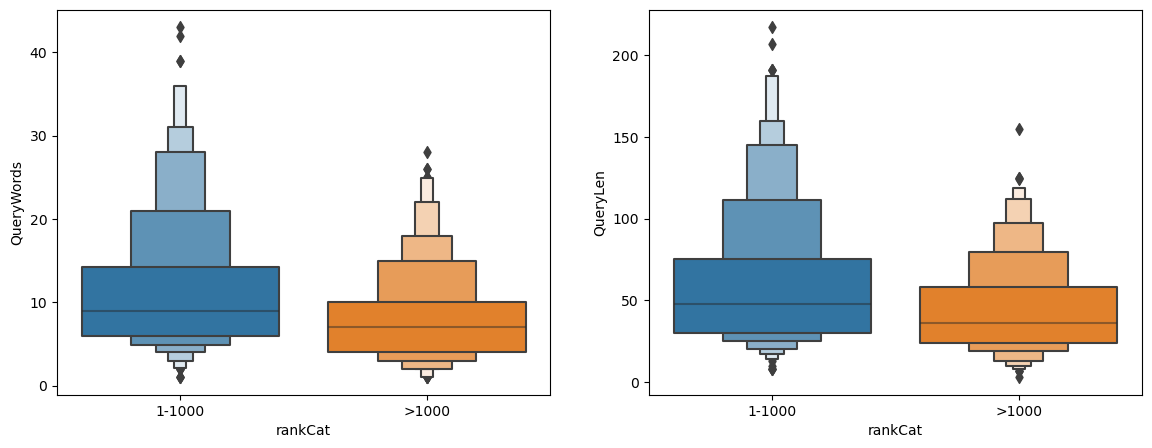

In [127]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", ax=ax[1])

In [128]:
from scipy.stats import ttest_ind
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryLen"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryLen"]))
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryWords"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryWords"]))

Ttest_indResult(statistic=5.35328528161696, pvalue=1.2400842752331476e-07)
Ttest_indResult(statistic=5.5646889953431655, pvalue=3.993943916182603e-08)


- The difference between unsuccessful and successful queries is significant w.r.t. query len and query words
    - but it is hardly a comprehensive description (there are large overlaps)

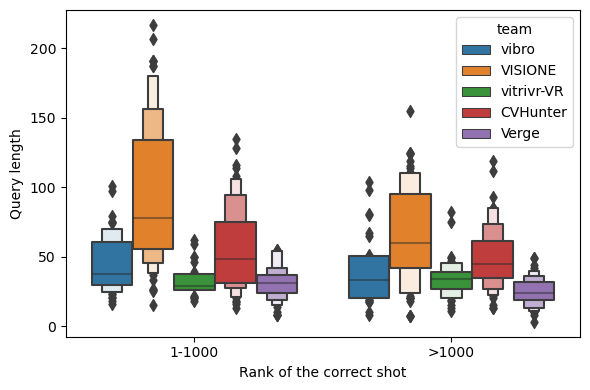

In [129]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1]
hue_order = team_order

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("TextQueryLengthVsRanking.pdf")

- there are very large differences in how individual teams lay queries
    - however, not much of whether they are successful or not depends on their outer characteristics (length)    

In [130]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

vibro
Ttest_indResult(statistic=0.8979428875027081, pvalue=0.3721283188416703)
Ttest_indResult(statistic=0.8671278646671642, pvalue=0.3886750827775899)
VISIONE
Ttest_indResult(statistic=3.9714654090272865, pvalue=0.00010647419208619813)
Ttest_indResult(statistic=3.8909133774127342, pvalue=0.000144624674552814)
vitrivr-VR
Ttest_indResult(statistic=-0.28624045218560434, pvalue=0.7756966589362554)
Ttest_indResult(statistic=-0.00652170399991897, pvalue=0.9948184717350408)
Verge
Ttest_indResult(statistic=3.4006024618753354, pvalue=0.0008812915781446039)
Ttest_indResult(statistic=2.585334254464897, pvalue=0.010773249735972924)
CVHunter
Ttest_indResult(statistic=1.6157194338632415, pvalue=0.10832874627692896)
Ttest_indResult(statistic=2.7507883263915653, pvalue=0.006703566034707051)


In [131]:
for team in textDataWithLength.team.unique():
    print(team)
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"].mean())
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"].mean())

vibro
45.75 40.892857142857146
8.625 7.75
VISIONE
95.36792452830188 67.22950819672131
18.67924528301887 13.180327868852459
vitrivr-VR
33.31818181818182 34.35897435897436
6.636363636363637 6.641025641025641
Verge
31.095890410958905 24.924242424242426
5.424657534246576 4.53030303030303
CVHunter
55.89873417721519 48.970588235294116
10.49367088607595 8.279411764705882


- the difference is significant especially for vibro and VERGE teams as well as CVHunter w.r.t. QueryWords
- insignificant for vitrivr-VR

### The same for video rank

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\2438374289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">1000"


<Axes: xlabel='rankCat', ylabel='QueryLen'>

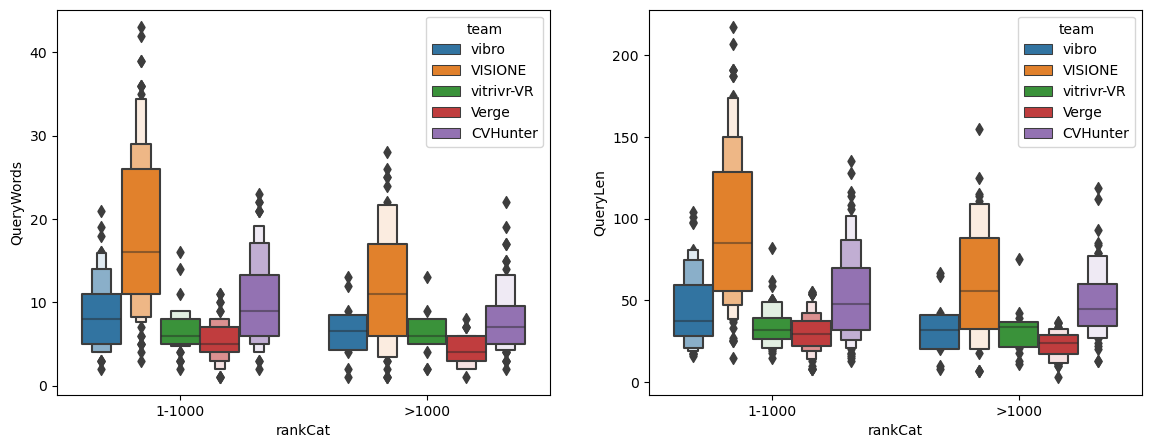

In [132]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_video <= 1000),"rankCat"] = "1-1000"
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax[1])

In [133]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

vibro
Ttest_indResult(statistic=1.5623768504402566, pvalue=0.12246596805897218)
Ttest_indResult(statistic=1.3718153168315788, pvalue=0.1742657687047411)
VISIONE
Ttest_indResult(statistic=4.170164863017988, pvalue=4.9064048814633925e-05)
Ttest_indResult(statistic=3.863091681499517, pvalue=0.00016058883532101966)
vitrivr-VR
Ttest_indResult(statistic=0.5541157593984858, pvalue=0.5815938814893361)
Ttest_indResult(statistic=0.3354423368255169, pvalue=0.7384812970090062)
Verge
Ttest_indResult(statistic=3.729889410919781, pvalue=0.00027960955478501263)
Ttest_indResult(statistic=2.7915582939214696, pvalue=0.0059952083998653935)
CVHunter
Ttest_indResult(statistic=1.4303599168502386, pvalue=0.1547651232640613)
Ttest_indResult(statistic=2.5157776447737317, pvalue=0.012966682359523966)


- For vibro and VERGE, out of range queries w.r.t. both videos and shots had significantly shorter queries w.r.t. both lengths and number of words in them

In [134]:
textualMaxTime = 420000
visualMaxTime = 300000
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="textual")),"correct_submission_time_ms"] = textualMaxTime
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="visual")),"correct_submission_time_ms"] = visualMaxTime

In [135]:
"""boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()"""

'boundaries = [0,60,120,180,240,300,360,420]\nboundaries = [b*1000 for b in boundaries]\nvalid_bins = []\ndataset["hist_bin"] = 0\n\nfor b in boundaries:\n    \n    if b > 0:\n        # checking whether the team was available throughout the whole period of the bin\n        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)\n        valid_bins.append("valid_"+str(b-60*1000))\n    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b\n    \ndataset.tail()'

In [136]:
boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000
1211,507,507,vbs23-kis-v5,CVHunter,1,1673278561140,14899,52222.0,12.0,12.0,...,21,4,0,False,False,False,False,False,False,False
1011,307,307,vbs23-kis-t5,CVHunter,1,1673262845945,19333,105663.0,2000.0,2000.0,...,30,5,0,True,False,False,False,False,False,False
1000,296,296,vbs23-kis-t4,CVHunter,0,1673262671653,348898,420000.0,142.0,142.0,...,128,22,300000,True,True,True,True,True,True,True
987,283,283,vbs23-kis-t4,CVHunter,0,1673262597224,274469,420000.0,148.0,148.0,...,101,18,240000,True,True,True,True,True,True,True
978,274,274,vbs23-kis-t4,CVHunter,1,1673262558979,236224,420000.0,2000.0,2000.0,...,72,11,180000,True,True,True,True,True,True,True


## Intensity of laying queries over time
- 30 second intervals
- normalized by the volume of still compeeting teams+task within that time window

In [137]:
#remove data that are from the histogram bins where the team submitted (i.e. did not continue throughout the bin duration)
validRestrData = dataset.copy()
print(validRestrData.shape)
for vb in valid_bins:
    validRestrData = validRestrData.loc[~((validRestrData[vb]==False)&(validRestrData["hist_bin"]>=int(vb.replace("valid_","")) ))]
print(validRestrData.shape)

(784, 32)
(576, 32)


In [138]:
bin_divisors = validRestrData.groupby(["team","task"])[valid_bins].max().sum()
bin_divisors.index = bin_divisors.index.str.replace("valid_","").astype(int)

In [139]:
hist_counts = validRestrData.groupby("hist_bin")["team"].count()

<Axes: xlabel='hist_bin'>

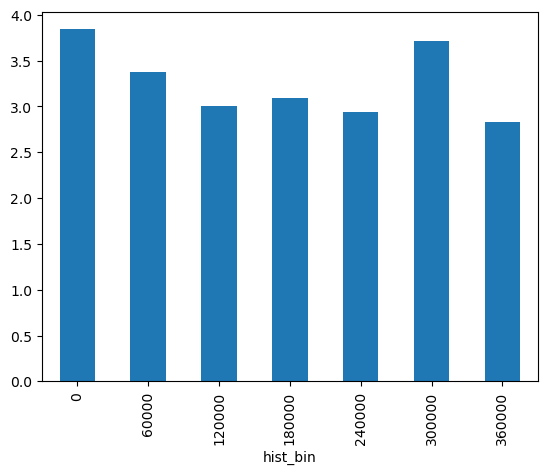

In [140]:
(hist_counts / bin_divisors).plot.bar()
#TODO make the graph publication-ready (descriptions etc.)

In [141]:
(hist_counts / bin_divisors)

hist_bin
0         3.842105
60000     3.371429
120000    3.000000
180000    3.090909
240000    2.941176
300000    3.714286
360000    2.833333
dtype: float64

### Observations:
- there are no huge differences, but still, the volume of queries per time tends to decrease a bit in the later stages of the search
- perhaps users already depleated ways to reformulate and focus more on the browsing
- the initial lower values are probably caused by the information processing gap (watching the scene, reading the description)

## Per-team querying density

In [142]:
#total availabe time to ask queries per team
totTime = dataset.groupby(["team","task"])[["correct_submission_time_ms"]].min().reset_index().groupby("team")["correct_submission_time_ms"].sum()
totTime

team
CVHunter      3247500.0
VISIONE       2205469.0
Verge         3538370.0
vibro         1896544.0
vitrivr-VR    1869350.0
Name: correct_submission_time_ms, dtype: float64

In [143]:
# per-team query density
# queryCount = dataset.groupby("team")["task"].count()
queryCount = dataset.groupby(["team", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team"]).count()
queryCount = queryCount['task']
queryCount

team
CVHunter      231
VISIONE       171
Verge         134
vibro         160
vitrivr-VR     61
Name: task, dtype: int64

In [144]:
queryPerMinute = queryCount/totTime*1000*60
queryPerMinute

team
CVHunter      4.267898
VISIONE       4.652072
Verge         2.272233
vibro         5.061839
vitrivr-VR    1.957900
dtype: float64

In [145]:
qpmdf = pd.DataFrame({"QPM":queryPerMinute})
qpmdf["QT"] = "Text"
qpmdf = qpmdf.set_index("QT", append=True)

In [146]:
resTab1["Query per Minute"] = qpmdf["QPM"]
resTab1 = resTab1.loc[team_order, ['Text','Other'], :]
print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2).to_latex())
#print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
      &       &  Query per Minute &  Words per query &  Query length &  top10 &  top20 &  top50 &  top100 &  top200 &  >1000 \\
team & QT &                   &                  &               &        &        &        &         &         &        \\
\midrule
vibro & Text &              5.06 &             7.13 &         38.28 &   11.5 &   19.5 &   28.7 &    33.3 &    39.1 &   32.2 \\
      & Other &               NaN &              NaN &           NaN &    3.8 &   11.2 &   23.8 &    31.2 &    36.2 &   38.8 \\
VISIONE & Text &              4.65 &            16.67 &         85.09 &   10.8 &   16.8 &   25.7 &    31.7 &    41.9 &   36.5 \\
vitrivr-VR & Text &              1.96 &             6.64 &         33.98 &    9.8 &   13.1 &   14.8 &    16.4 &    24.6 &   63.9 \\
CVHunter & Text &              4.27 &             9.47 &         52.69 &   10.9 &   12.2 &   15.0 &    20.4 &    29.9 &   46.3 \\
      & Other &               NaN &              NaN & 

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\1839281114.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2).to_latex())


In [147]:
resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200"]].round(2)

Query per Minute  Words per query  Query length  top10  \
team       QT                                                              
vibro      Text               5.06             7.13         38.28   11.5   
           Other               NaN              NaN           NaN    3.8   
VISIONE    Text               4.65            16.67         85.09   10.8   
vitrivr-VR Text               1.96             6.64         33.98    9.8   
CVHunter   Text               4.27             9.47         52.69   10.9   
           Other               NaN              NaN           NaN    4.8   
Verge      Text               2.27             5.00         28.17    0.7   
           Other               NaN              NaN           NaN   15.4   

                  top20  top50  top100  top200  
team       QT                                   
vibro      Text    19.5   28.7    33.3    39.1  
           Other   11.2   23.8    31.2    36.2  
VISIONE    Text    16.8   25.7    31.7    41.9  
vitrivr-VR Text    13.1   14.8    16.4    24.6  
CVHunter   Text    12.2   15.0    20.4    29.9  
           Other    8.3   13.1    20.2    25.0  
Verge      Text     1.4    2.9     4.3    27.3  
           Other   15.4   15.4    23.1    23.1

### Observations:
- vitrivr-VR is notably slower in query construction (or just spent much more time in browsing - is it VR to blame?)
- VISIONE and vibro depended more heavily on querying

In [148]:
queryCount = dataset.groupby(["team","user"])["task"].count()
queryCount

team        user
CVHunter    0       105
            1       126
VISIONE     0        50
            1       123
Verge       0       152
vibro       0        76
            1        91
vitrivr-VR  0        38
            1        23
Name: task, dtype: int64

- does not look like so notable differences among individual users... skip for now

## Initial response time
- how quickly did individual teams managed to ask their first query?

In [149]:
initTime = (dataset.groupby(["team","task","user","task_type"])[["elapsed_since_task_start_ms"]].min()/1000).reset_index()

In [150]:
initTime.groupby(["team","task_type"]).mean()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\2926304620.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["team","task_type"]).mean()["elapsed_since_task_start_ms"]


team        task_type
CVHunter    textual      24.906286
            visual       14.585625
VISIONE     textual      20.116857
            visual       15.461708
Verge       textual      33.344429
            visual       31.008889
vibro       textual      22.631571
            visual       17.324000
vitrivr-VR  textual      51.527333
            visual       41.811190
Name: elapsed_since_task_start_ms, dtype: float64

In [151]:
initTime.groupby(["team","task_type"]).median()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\3133183519.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["team","task_type"]).median()["elapsed_since_task_start_ms"]


team        task_type
CVHunter    textual      22.1820
            visual       13.9690
VISIONE     textual      19.2780
            visual       15.3995
Verge       textual      32.7360
            visual       31.4920
vibro       textual      23.9110
            visual       16.1450
vitrivr-VR  textual      44.5090
            visual       36.5190
Name: elapsed_since_task_start_ms, dtype: float64

In [152]:
initTime.groupby(["team","task_type"]).min()["elapsed_since_task_start_ms"]

team        task_type
CVHunter    textual      13.617
            visual        8.361
VISIONE     textual      13.273
            visual        8.302
Verge       textual      26.051
            visual       14.814
vibro       textual       6.245
            visual        6.343
vitrivr-VR  textual      32.105
            visual       18.476
Name: elapsed_since_task_start_ms, dtype: float64

In [153]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.task=="vbs22-kis-t09"))]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000


In [154]:
initTime.groupby(["task_type"]).mean()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_22316\3085733443.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["task_type"]).mean()["elapsed_since_task_start_ms"]


task_type
textual    28.350397
visual     22.490461
Name: elapsed_since_task_start_ms, dtype: float64

<Axes: xlabel='team', ylabel='elapsed_since_task_start_ms'>

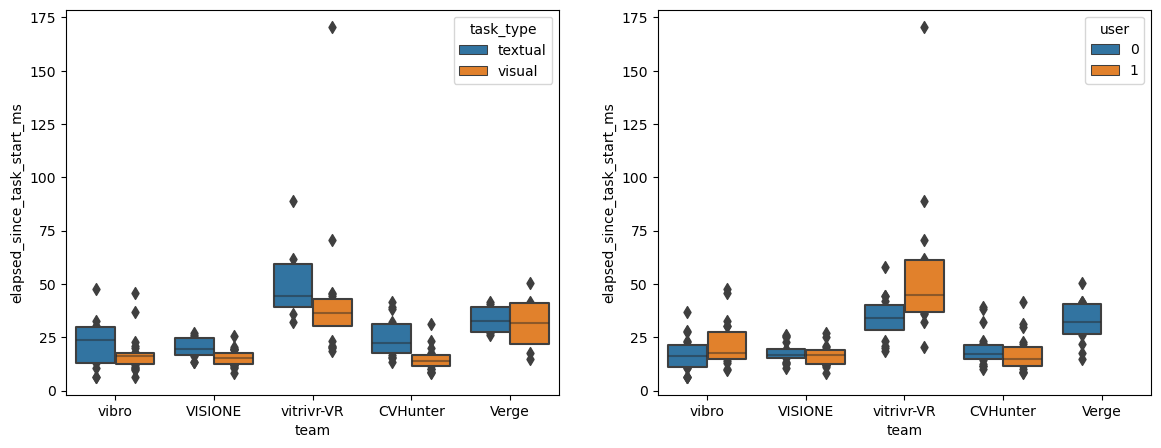

In [155]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="task_type", ax=ax[0], order=team_order)
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="user", ax=ax[1], order=team_order)

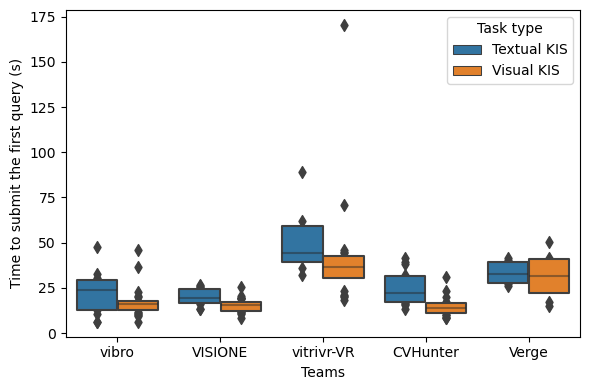

In [156]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
initTime["Task type"] = "Textual KIS"
initTime.loc[initTime.task_type=="visual","Task type"] = "Visual KIS"

sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="Task type", ax=ax, order=team_order)

ax.set_xlabel("Teams")
ax.set_ylabel("Time to submit the first query (s)")
plt.tight_layout()
plt.savefig("TimeToFirstQueryPerTeam.pdf")

In [157]:
print(ttest_ind(initTime.loc[initTime.team == "vitrivr-VR","elapsed_since_task_start_ms"],initTime.loc[initTime.team != "vitrivr-VR","elapsed_since_task_start_ms"]))

Ttest_indResult(statistic=8.25957905627412, pvalue=5.521016557216569e-14)


In [158]:
print(ttest_ind(initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Textual KIS")),"elapsed_since_task_start_ms"],initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Visual KIS")),"elapsed_since_task_start_ms"]))

Ttest_indResult(statistic=nan, pvalue=nan)


- not much difference between task types (a bit surprising, I was expecting longer times for visual tasks)
- vitrivr-VR has considerably & significantly larger times than all other teams (again, blaim VR or more focused on browsing from the beginning?)
- some variance between users, but not quite sure what to get from that...

# How (how much) reformulations help?

In [159]:
ranks = []
lastRank = 0
lastRecord = (0,0,0)
#TODO: only for textual reformulations
sortedData = textData.sort_values(["task","team","user","timestamp"])
for idx, row in sortedData.iterrows():
    record = (row["task"],row["team"],row["user"])
    if record != lastRecord:
        lastRecord = record
        lastRank = 0
    lastRank += 1
    ranks.append(lastRank)

sortedData["QueryRank"] = ranks

#record how long was the interaction for each task and user
querySeriesLen = sortedData.groupby(["task","team","user"])[["QueryRank"]].max()
querySeriesLen.columns = ["MaxQueryRank"]
sortedData = sortedData.join(querySeriesLen, on=["task","team","user"])
sortedData.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords,rankCat,QueryRank,MaxQueryRank
753,49,49,vbs23-kis-t1,CVHunter,0,1673260392327,19466,345478.0,18.0,522.0,...,False,True,"[119, 110, 122, 121, -128, -123, -118, -125, 124, 125, -124, 121, -121, -124, 124, -120, 127, -120, 115, 123, 126, -119, -116, 126, -119, -125, -128, -124, 116, 108, 112, -123, 127, -127, -126, -120, -127, 118, -121, 117, 127, 124, 127, 125, -126, 121, -116, -128, -121, 119, 118, 122, -119, 120, 121, 120, -119, -127, 126, -127, -124, -127, 121, -117, -128, -127, -121, -124, -127, -115, 120, 122, 124, -121, -120, -123, -126, 125, 126, 127, -123, -126, -126, -128, -116, -127, 125, 123, 120, -124, -123, -128, -126, 126, -128, -125, -121, 125, -127, 125, ...]",textual,Text,42,8,1-1000,1,5
761,57,57,vbs23-kis-t1,CVHunter,0,1673260425436,52575,345478.0,185.0,255.0,...,True,True,"[124, 107, 119, -128, 125, -127, -121, -122, -124, 127, -123, 123, -119, -128, -128, -117, 122, -126, 114, 124, 120, -119, -123, 127, -118, -124, -128, -122, 118, 111, 119, 127, 125, -127, -124, -120, -122, 119, -119, 119, 125, 123, 124, -124, -125, 118, -122, -127, -127, -128, 120, 124, -119, 120, 116, 116, -126, -125, 116, -126, -125, 122, -126, -118, 125, -125, 122, -125, 127, -118, 122, 116, 124, -123, -118, -128, 121, 120, 124, -123, -128, -128, 124, -127, -117, -128, -127, 123, 122, -126, -126, 124, -126, 126, -127, -125, -118, 119, 126, -127, ...]",textual,Text,58,10,1-1000,2,5
765,61,61,vbs23-kis-t1,CVHunter,0,1673260450068,77207,345478.0,89.0,459.0,...,True,True,"[124, 110, 119, 112, 121, -124, -126, -123, 126, 127, -119, 123, -123, 125, 124, -116, 125, -123, 118, 124, 118, -125, -127, -128, -119, -121, -128, -126, 113, 115, 109, -122, 124, -119, -125, -122, -127, 121, -117, 116, -127, 122, 121, -126, -127, 121, -115, 122, -116, 121, 118, 121, -119, 120, 124, 120, -121, -124, 116, -122, -127, 126, 116, -111, -122, -125, -122, -120, 122, -114, 121, 119, 118, -118, -120, -122, -126, 125, 119, -124, -125, 126, -128, 127, -123, 126, 122, 124, 120, -127, -119, 125, 123, 127, 124, -125, -118, 126, -124, 121, ...]",textual,Text,48,10,1-1000,3,5
769,65,65,vbs23-kis-t1,CVHunter,0,1673260470489,97628,345478.0,142.0,375.0,...,True,True,"[125, 111, 122, 107, 121, -123, -126, -121, 127, -127, -118, 124, -124, 120, 124, -117, 125, -123, 119, 122, 120, -122, -124, -126, -116, -121, -128, -125, 111, 114, 111, -122, 122, -117, -126, -123, -127, 120, -121, 118, -128, 122, 120, -126, -125, 123, -115, 119, -117, 120, 118, 122, -119, 116, 124, 118, -121, -124, 114, -122, -128, 127, 118, -111, -125, -126, -124, -116, 123, -112, 124, 119, 120, -120, -121, -123, -128, 127, 120, -122, 127, 126, 126, 125, -125, 125, 121, 124, 122, -125, -119, 124, 122, 125, 123, -127, -117, 127, -125, 120, ...]",textual,Text,64,13,1-1000,4,5
773,69,69,vbs23-kis-t1,CVHunter,0,1673260510154,137293,345478.0,7.0,44.0,...,True,True,"[123, 112, 120, 115, 121, -122, -124, -116, -128, -128, -116, -128, -123, 124, 125, -114, 125, -118, 115, 118, 126, -118, -120, -125, -111, -123, -128, -124, 116, 118, 114, -120, 119, -115, -128, -120, 126, 126, -124, 120, 126, 122, 123, -127, -125, 125, -116, 121, -119, 122, 120, 122, -116, 117, 124, 123, -122, -122, 117, -121, -127, -127, 113, -116, -124, -125, -128, -116, 122, -117, 123, 115, 116, -124, -123, -120, -127, -127, 118, -124, -124, -125, 126, 127, -127, -124, 122, 122, 126, -126, -119, -128, -126, 126, 121, -128, -117, 127, -126, 123, ...]",textual,Text,75,15,1-1000,5,5


[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

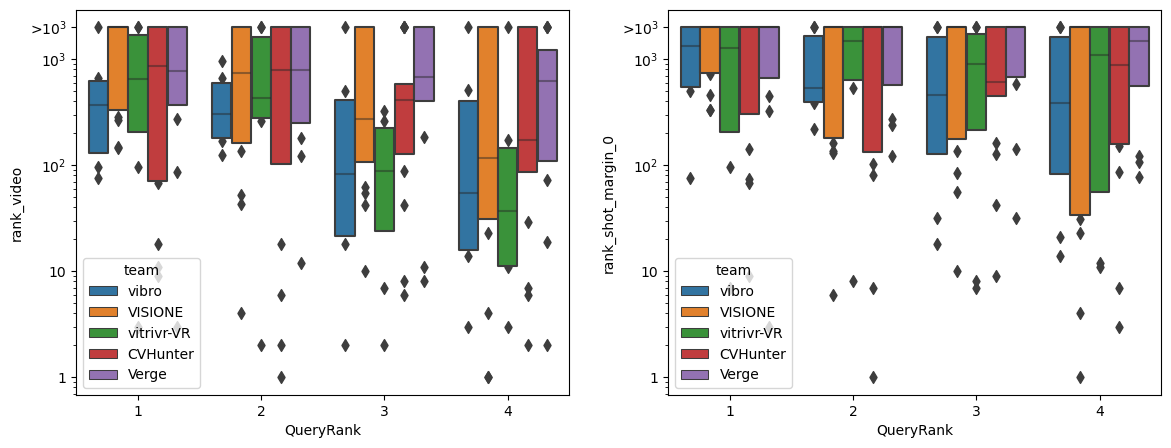

In [160]:
dt = sortedData.loc[((sortedData.QueryRank <= 4)&(sortedData.MaxQueryRank >= 4))]
dt = dt.sort_values(by='team', key=lambda x: x.map({v: i for i, v in enumerate(team_order)}))

fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", hue="team", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0", hue="team", ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

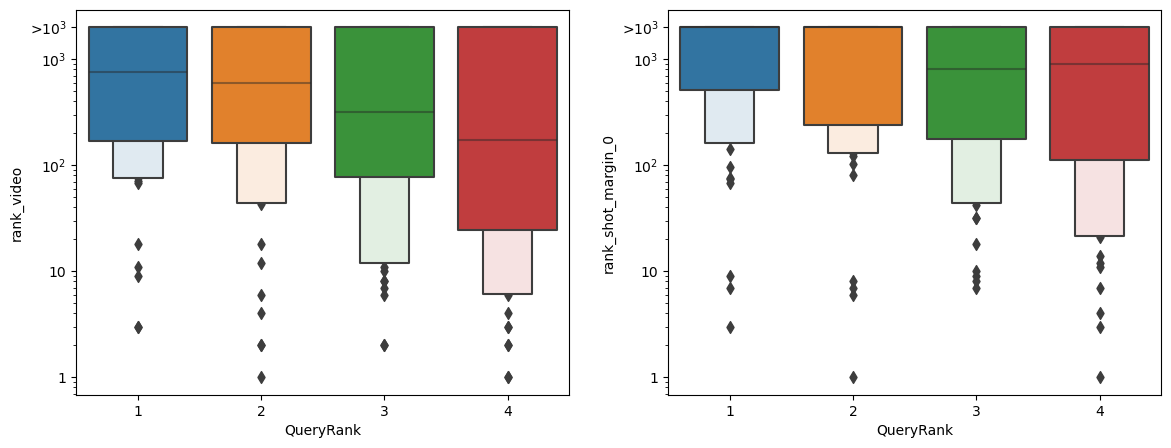

In [161]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

## Observations:
- quite notably, reformulation helps: throughout most of the teams and also in average
- there were multiple cases, when query results were quite good (10 - 10^2), but they were reformulated anyway -> blaim GUI?
- was thinking about directly comparing (previous - next) query ranks, but out-of-range results would make this comparison inconsistent

### The same, but counting query reformulations from the last query backwards 
- i.e., -3 denotes three queries before the last one made by the user for that particular task
- only sessions with 4+ queries were kept

[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

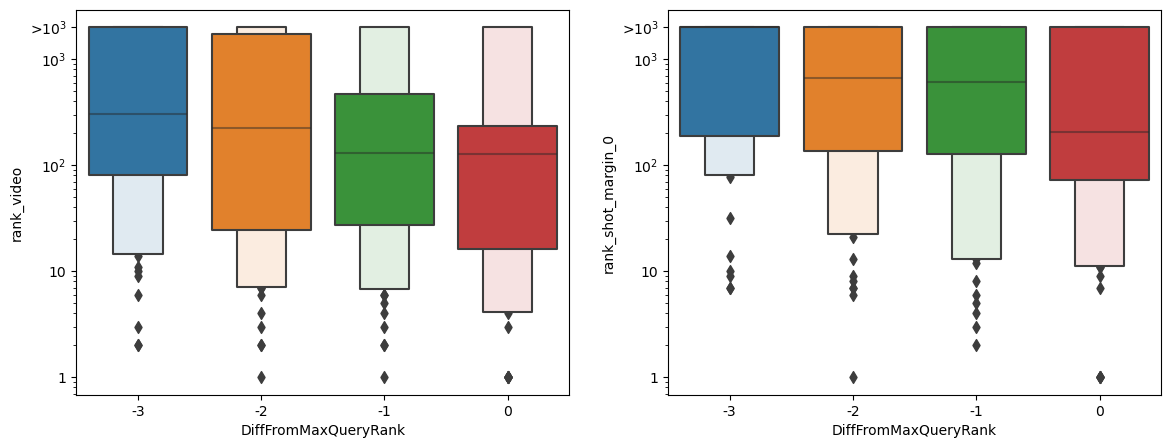

In [162]:
sortedData["DiffFromMaxQueryRank"] = sortedData.QueryRank - sortedData.MaxQueryRank
dt2 = sortedData.loc[((sortedData.DiffFromMaxQueryRank >= -3)&(sortedData.MaxQueryRank > 3))]
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

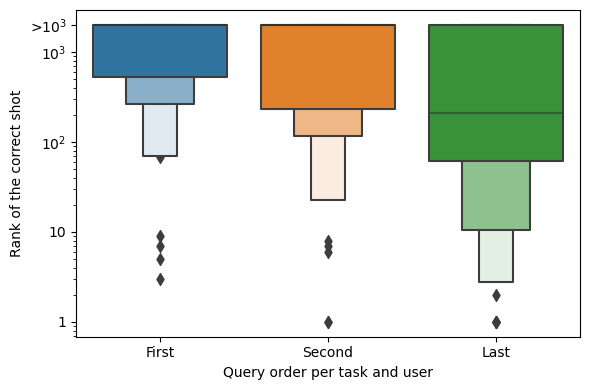

In [163]:
sortedData["RankForViz"] = -1
sortedData.loc[sortedData["QueryRank"]==1,"RankForViz"] = 1
sortedData.loc[sortedData["QueryRank"]==2,"RankForViz"] = 2
#sortedData.loc[sortedData["QueryRank"]==3,"RankForViz"] = 3
sortedData.loc[sortedData["DiffFromMaxQueryRank"]==0,"RankForViz"] = 3

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,1, figsize=(6,4))

sns.boxenplot(data=dt2,x="RankForViz",y="rank_shot_margin_0",  ax=ax)
#sns.boxenplot(data=dt2,x="RankForViz",y="rank_video", ax=ax[1])


#ax[1].set_yscale("log")
#ax[1].set_yticks([1,10,100,1000,2000])
#ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
#ax[1].set_xlabel("Query order per task and user")
#ax[1].set_ylabel("Best rank of a shot from the correct video")

ax.set_yscale("log")
ax.set_yticks([1,10,100,1000,2000])
ax.set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
ax.set_xticklabels(["First","Second","Last"])
ax.set_xlabel("Query order per task and user")
ax.set_ylabel("Rank of the correct shot")

plt.tight_layout()
plt.savefig("QueryReformulation.pdf")


Text(0, 0.5, 'Rank of the correct shot')

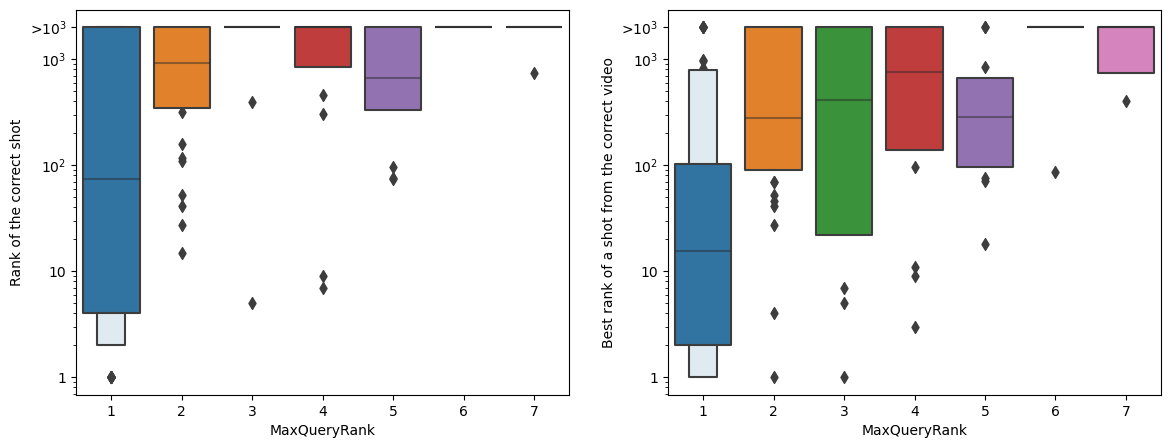

In [164]:
#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.QueryRank == 1)&(sortedData.MaxQueryRank <= 7))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_shot_margin_0",  ax=ax[0])
sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_video", ax=ax[1])


ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


ax[1].set_ylabel("Best rank of a shot from the correct video")

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[0].set_ylabel("Rank of the correct shot")



Text(0, 0.5, 'Rank of the correct shot')

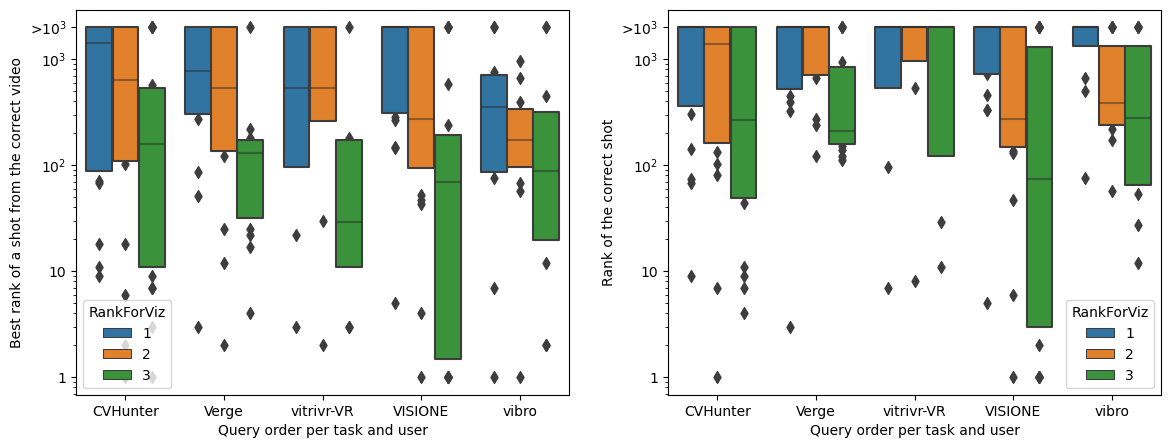

In [165]:

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_shot_margin_0",  ax=ax[1])
sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_video", ax=ax[0])


ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[0].set_xticklabels(["First","Second","Last"])
ax[0].set_xlabel("Query order per task and user")
ax[0].set_ylabel("Best rank of a shot from the correct video")

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
ax[1].set_xlabel("Query order per task and user")
ax[1].set_ylabel("Rank of the correct shot")

In [166]:
dt2.groupby(["team","DiffFromMaxQueryRank"])[["rank_video","rank_shot_margin_0"]].median()

rank_video  rank_shot_margin_0
team       DiffFromMaxQueryRank                                
CVHunter   -9                        1427.5              1427.5
           -8                        2000.0              2000.0
           -7                        2000.0              2000.0
           -6                        1066.5              1066.5
           -5                        2000.0              2000.0
           -4                         148.0              2000.0
           -3                          11.0               255.0
           -2                         253.0              2000.0
           -1                         474.0               474.0
            0                         158.0               266.0
VISIONE    -20                        411.0              2000.0
           -19                       2000.0              2000.0
           -18                       2000.0              2000.0
           -16                        144.0               734.0
           -15                        135.0               136.0
           -7                         149.0               332.0
           -6                        2000.0              2000.0
           -5                        2000.0              2000.0
           -4                         331.0               726.0
           -3                         755.0              2000.0
           -2                         275.0               275.0
           -1                          24.0                24.0
            0                          70.0                74.0
Verge      -19                        447.0               447.0
           -18                        877.0               877.0
           -16                       2000.0              2000.0
           -15                       1411.0              2000.0
           -14                        226.0              1163.0
           -13                        275.0               275.0
           -10                       2000.0              2000.0
           -9                         372.0               661.0
           -6                         570.0              1369.0
           -5                         702.0              2000.0
           -4                        2000.0              2000.0
           -3                        1061.0              1061.0
           -2                        1025.5              1196.5
           -1                          13.5              2000.0
            0                         130.5               209.5
vibro      -12                        505.0               505.0
           -11                        393.0               393.0
           -5                        2000.0              2000.0
           -4                         451.5              1335.0
           -3                         194.0              1335.0
           -2                         239.5              2000.0
           -1                          68.0               261.0
            0                          89.0               276.0
vitrivr-VR -4                         315.5               315.5
           -3                         649.0              1479.5
           -2                         409.0              2000.0
           -1                         603.0              2000.0
            0                          29.0              2000.0